# Imports

In [ ]:


from typing import *
from collections import defaultdict
from PIL import Image
from IPython.display import display
import copy
from glob import glob
import re
import os
from random import shuffle
import time
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import xml.etree.ElementTree as ET
import numpy as np


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision import transforms, models

!pip install timm # library containing popular models (including ViT)
import timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 22.1 MB/s eta 0:00:00


# Data

import dataset into runtime

In [ ]:
!gdown --id 1zre8_TMtUeHZkQKcOTTueNcAqY_aXJFU
!mkdir training
!tar -xzf resized_dataset.tar.gz -C training

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zre8_TMtUeHZkQKcOTTueNcAqY_aXJFU
To: /content/resized_dataset.tar.gz
100% 274M/274M [00:02<00:00, 94.6MB/s]


In [ ]:
# change num_countries to the number you want (maximum is 19)
num_countries = 19



In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
base_dir = '/content/training'

import os
import glob
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Function to load images and labels from your folder structure
def load_images_and_labels(base_dir, num_countries, max_per_country=1500):
    # dictionaries to be populated with pairing from numbers to the label they correspond to i.e 0: "Canada", 1: "Russia", etc.
    label_to_index = {}
    index_to_label = {}
    images = []
    labels = []
    
    # get all the folders from the base directory or small subset if use_small is true
    folders = os.listdir(base_dir)[:num_countries]


    # Iterate over the folders 
    for index, folder in enumerate(folders):
        folder_path = os.path.join(base_dir, folder)
        
        # Check if it's a directory and has the expected structure
        if os.path.isdir(folder_path):
            image_files = glob.glob(os.path.join(folder_path, 'canvas_*.jpg'))
            print(f"loading { min(len(image_files), max_per_country) } images from {folder}")
            
            #print(f"{folder}: {len(image_files)}")
            label = folder
            index_to_label[index] = label
            label_to_index[label] = index
            
            # Iterate over the image files inside the folder
            for i, image_file in enumerate(image_files):
                if i >= max_per_country:
                  break

                # Read the image using PIL
                image = Image.open(image_file)
                
                # Append the image and label to the corresponding lists
                # image = image.resize((256,256)) #resize images to 256x256 - dataset already in 256x256 now
                images.append(image) 
                labels.append(label)
    
    return label_to_index, index_to_label, images, labels

Store loaded data into custom dataset class:

In [ ]:
# wrap the data in Dataset class for ease of use later
# need this transform to make images the expected size for transformer
transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    ])

class ImageDataset(Dataset):
  def __init__(self, images, labels, label_to_index, transform=transform, target_transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.target_transform = None
        self.label_to_index = label_to_index
       

  def __len__(self):
        return len(self.labels)

  def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]

        if self.transform:
          image = self.transform(image)
        if self.target_transform:
          label = self.target_transform(label)

        return image, self.label_to_index[label] # convert label to index 



  


Create Dataloaders from dataset

In [ ]:
def make_data_loaders(dataset, batch_size=32, train_frac=0.8):

  length = len(dataset)

  # remainder of data split equally into test and validation sets
  test_frac = (1 - train_frac) / 2

  train_len = int(train_frac * length)
  test_len = int(test_frac * length)
  val_len = length - train_len - test_len

  train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_len, val_len, test_len])

  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, prefetch_factor=8)
  val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2, prefetch_factor=8)
  test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2, prefetch_factor=8)
  
  return train_loader, val_loader, test_loader

# Transformer

load pretrained vision transformer

In [ ]:
def get_model():
  model = timm.create_model('vit_large_patch16_224_in21k', pretrained=True)

  device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
  print(device)

  for param in model.parameters():
      param.requires_grad = False

  model.head = nn.Sequential(nn.Linear(1024, 512),
                                  nn.ReLU(),
                                  nn.Dropout(0.2),
                                  nn.Linear(512, num_countries))

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.head.parameters(), lr=0.003)
  model.to(device)

  return model, device, criterion, optimizer

Train Model:

In [ ]:
def get_loaders(batch_size, max_per_country):
  label_to_index, index_to_label, images, labels = load_images_and_labels(base_dir, num_countries, max_per_country=max_per_country)
  dataset = ImageDataset(images, labels, label_to_index)
  train_loader, val_loader, test_loader = make_data_loaders(dataset, batch_size=batch_size)
  return train_loader, val_loader, test_loader

In [ ]:
def train(train_loader, test_loader, num_batches):
  model, device, criterion, optimizer, = get_model()
 
  # training loop
  summed_train_loss = 0
  num_data_points = 15
  test_every = num_batches // num_data_points # get 15 data points
  train_losses, test_losses, test_accuracies = [], [], []
  batch_numbers = []
  batches_processed = 0

  while batches_processed < num_batches:
    for (train_inputs, train_labels) in train_loader:

        model.train() # set in training mode

        train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)
        optimizer.zero_grad()

        train_outputs = model.forward(train_inputs)
        train_loss = criterion(train_outputs, train_labels)
        train_loss.backward()

        optimizer.step()
        summed_train_loss += train_loss.item()
       
        batches_processed += 1

        # get test accuracy:
        if batches_processed == 1 or batches_processed % test_every == 0:

          total_correct = 0
          total_images = 0
          summed_loss = 0
          model.eval() # set in eval mode

          with torch.no_grad():
            for j, (inputs, labels) in enumerate(test_loader):
              inputs, labels = inputs.to(device), labels.to(device)

              outputs = model.forward(inputs)
              pred = outputs.argmax(axis=1)
              num_correct = (pred == labels).sum().item()

              loss = criterion(outputs, labels)
              summed_loss += loss.item()

              total_images += len(labels)
              total_correct += num_correct
        
          test_loss = summed_loss/len(test_loader)
          test_accuracy = 100 * (total_correct / total_images)
          
          train_loss = summed_train_loss/(batches_processed)
          train_losses.append(train_loss)

          test_losses.append(test_loss)
          test_accuracies.append(test_accuracy)

          batch_numbers.append(batches_processed)

            
          print(f"Batch [{batches_processed}/{num_batches}]: "
            f"Train loss: {train_loss:.3f}.. "
            f"Test loss: {test_loss:.3f}.. "
            f"Test accuracy: {test_accuracy:.3f}.. %")
          
        # once we have trained on enough batches, break the loop
        if batches_processed >= num_batches:
          break
        
  return model, (batch_numbers, test_accuracies)

In [ ]:
def run_validation(val_loader, modelname):
  model = torch.load(modelname).cuda().eval()

  total_correct = 0
  total_images = 0

  for i, (inputs, labels) in enumerate(val_loader):
      
      inputs, labels = inputs.cuda(), labels.cuda()

      total_images += len(labels)

      outputs = model.forward(inputs)
      pred = outputs.argmax(axis=1)
      num_correct = (pred == labels).sum().item()
      total_correct += num_correct

  print (f"overall validation accuracy: {total_correct}\\{total_images} == {(total_correct / total_images) * 100}%")

Train with different batch sizes, dataset sizes:

In [ ]:
# Batch size = 16, images per country = 500
train_loader, val_loader, test_loader = get_loaders(batch_size=16, max_per_country=500)
model, test_accs_16_500 = train(train_loader, test_loader, num_batches=1000)
torch.save(model, "transformer_16_500")
run_validation(val_loader, "transformer_16_500")

loading 500 images from Spain
loading 500 images from Thailand
loading 500 images from United States
loading 500 images from Mexico
loading 500 images from Russia
loading 500 images from Finland
loading 500 images from Singapore
loading 500 images from Japan
loading 500 images from Canada
loading 500 images from Australia
loading 500 images from United Kingdom
loading 500 images from Poland
loading 500 images from Germany
loading 500 images from Brazil
loading 500 images from South Africa
loading 500 images from Italy
loading 500 images from Sweden
loading 500 images from France
loading 500 images from Argentina
cuda
Batch [1/1000]: Train loss: 2.986.. Test loss: 4.007.. Test accuracy: 10.432.. %
Batch [66/1000]: Train loss: 2.578.. Test loss: 2.489.. Test accuracy: 21.918.. %
Batch [132/1000]: Train loss: 2.337.. Test loss: 2.457.. Test accuracy: 21.391.. %
Batch [198/1000]: Train loss: 2.222.. Test loss: 2.470.. Test accuracy: 23.920.. %
Batch [264/1000]: Train loss: 2.166.. Test los

In [ ]:
# Batch size = 16, images per country = 1500

train_loader, val_loader, test_loader = get_loaders(batch_size=16, max_per_country=1500)
model, test_accs_16_1500 = train(train_loader, test_loader, num_batches=1000)
torch.save(model, "transformer_16_1500")
run_validation(val_loader, "transformer_16_1500")

cuda
loading 1075 images from Spain
loading 944 images from Thailand
loading 1500 images from United States
loading 901 images from Mexico
loading 1500 images from Russia
loading 1049 images from Finland
loading 707 images from Singapore
loading 1500 images from Japan
loading 1382 images from Canada
loading 1500 images from Australia
loading 1500 images from United Kingdom
loading 863 images from Poland
loading 698 images from Germany
loading 1500 images from Brazil
loading 1183 images from South Africa
loading 789 images from Italy
loading 726 images from Sweden
loading 1500 images from France
loading 689 images from Argentina
Batch [1/1000]: Train loss: 2.953.. Test loss: 4.727.. Test accuracy: 7.349.. %
Batch [66/1000]: Train loss: 2.566.. Test loss: 2.573.. Test accuracy: 20.977.. %
Batch [132/1000]: Train loss: 2.291.. Test loss: 2.515.. Test accuracy: 22.512.. %
Batch [198/1000]: Train loss: 2.186.. Test loss: 2.419.. Test accuracy: 26.047.. %
Batch [264/1000]: Train loss: 2.122.

In [ ]:
# Batch size = 32, images per country = 500

train_loader, val_loader, test_loader = get_loaders(batch_size=32, max_per_country=500)
model, test_accs_32_500 = train(train_loader, test_loader, num_batches=500)
torch.save(model, "transformer_32_500")
run_validation(val_loader, "transformer_32_500")

cuda
loading 500 images from Spain
loading 500 images from Thailand
loading 500 images from United States
loading 500 images from Mexico
loading 500 images from Russia
loading 500 images from Finland
loading 500 images from Singapore
loading 500 images from Japan
loading 500 images from Canada
loading 500 images from Australia
loading 500 images from United Kingdom
loading 500 images from Poland
loading 500 images from Germany
loading 500 images from Brazil
loading 500 images from South Africa
loading 500 images from Italy
loading 500 images from Sweden
loading 500 images from France
loading 500 images from Argentina
Batch [1/500]: Train loss: 3.045.. Test loss: 3.566.. Test accuracy: 11.380.. %
Batch [33/500]: Train loss: 2.630.. Test loss: 2.631.. Test accuracy: 20.232.. %
Batch [66/500]: Train loss: 2.344.. Test loss: 2.442.. Test accuracy: 24.341.. %
Batch [99/500]: Train loss: 2.194.. Test loss: 2.514.. Test accuracy: 23.182.. %
Batch [132/500]: Train loss: 2.100.. Test loss: 2.41

In [ ]:
# Batch size = 32, images per country = 1500

train_loader, val_loader, test_loader = get_loaders(batch_size=32, max_per_country=1500)
model, test_accs_32_1500 = train(train_loader, test_loader, num_batches=500)
torch.save(model, "transformer_32_1500")
run_validation(val_loader, "transformer_32_1500")

cuda
loading 1075 images from Spain
loading 944 images from Thailand
loading 1500 images from United States
loading 901 images from Mexico
loading 1500 images from Russia
loading 1049 images from Finland
loading 707 images from Singapore
loading 1500 images from Japan
loading 1382 images from Canada
loading 1500 images from Australia
loading 1500 images from United Kingdom
loading 863 images from Poland
loading 698 images from Germany
loading 1500 images from Brazil
loading 1183 images from South Africa
loading 789 images from Italy
loading 726 images from Sweden
loading 1500 images from France
loading 689 images from Argentina
Batch [1/500]: Train loss: 3.044.. Test loss: 4.024.. Test accuracy: 10.651.. %
Batch [33/500]: Train loss: 2.578.. Test loss: 2.484.. Test accuracy: 23.860.. %
Batch [66/500]: Train loss: 2.280.. Test loss: 2.360.. Test accuracy: 26.930.. %
Batch [99/500]: Train loss: 2.152.. Test loss: 2.359.. Test accuracy: 28.465.. %
Batch [132/500]: Train loss: 2.081.. Test



# Training Plots

Plot training loss verse batches:

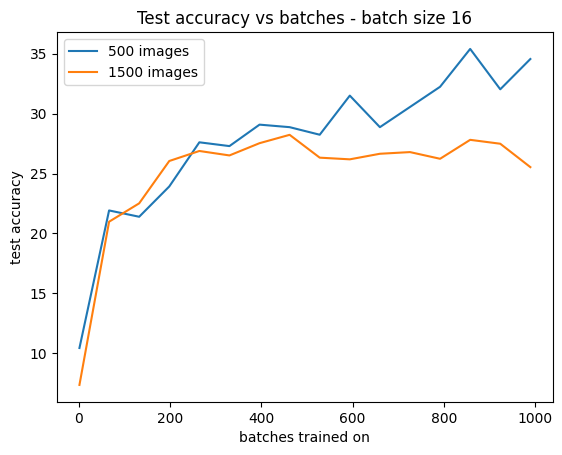

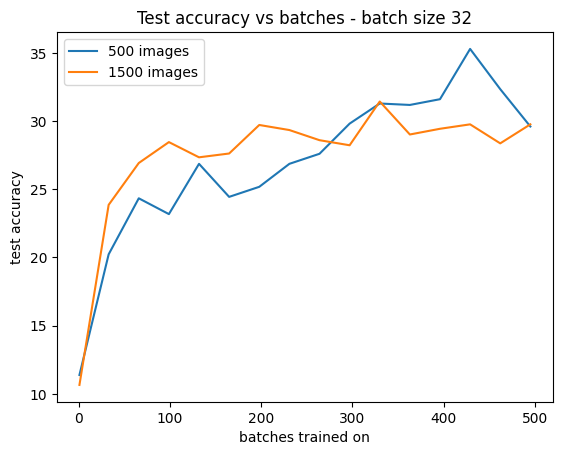

In [ ]:
def plot_test_accuracies(data_500, data_1500, title):

  
  plt.title(title)
  plt.xlabel("batches trained on")
  plt.ylabel("test accuracy")
  
  plt.plot(data_500[0], data_500[1], label="500 images")
  plt.plot(data_1500[0], data_1500[1], label="1500 images")
  plt.legend()
  plt.show()

plot_test_accuracies(test_accs_16_500, test_accs_16_1500, title="Test accuracy vs batches - batch size 16")
plot_test_accuracies(test_accs_32_500, test_accs_32_1500, title="Test accuracy vs batches - batch size 32")

# Predicitons

Run validation to see rough final accuracy: